In [20]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import pathlib

import numpy as np
import xarray as xr
import webdataset as wds
import dask.config

from dask.distributed import Client, LocalCluster

from mjonet import era5

USER = os.environ['USER']

if os.environ['NERSC_HOST'] == 'perlmutter':
    SCRATCH = f'/pscratch/sd/{USER[0]}/{USER}/'
else:
    SCRATCH = f'/global/cscratch1/sd/{USER}/'

save_dir = os.path.join(SCRATCH, 'data/era5/wds/debug')

if not os.path.exists(save_dir):
    pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
glob_dict = era5.make_glob_dict(exclude_vars=['mtnlwrf'], years=['197901'])
fpath_dict = era5.get_filepaths(glob_dict)

{var_name: len(paths) for var_name, paths in fpath_dict.items()}

{'sp': 1,
 'tcwv': 1,
 'msl': 1,
 '10u': 1,
 '10v': 1,
 '2t': 1,
 'z': 31,
 't': 31,
 'u': 31,
 'v': 31,
 'r': 31}

In [3]:
%%time

with dask.config.set({'temporary-directory': '/tmp'}), LocalCluster(n_workers=16, threads_per_worker=2) as cluster, Client(cluster) as client:
    print(client)
    era5.create_wds(fpath_dict,
                    save_dir=save_dir,
                    samples_per_tar=28, # one week
                    stage='197901',
                    target_steps=[6],
                    plevels={
                        'z': [50, 500, 850, 1000],
                        't': [500, 850],
                        'u': [500, 850, 1000],
                        'v': [500, 850, 1000],
                        'r': [500, 850],
                    },
                    chunks={ 'time': 4 },
                    parallel=True,
                    overwrite=True,
                    verbose=True)

/global/homes/j/jpduncan/.conda/envs/mjonet-preproc/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42823 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:46477' processes=16 threads=32, memory=224.61 GiB>
Preprocessing 161 files...
Datasets opened and combined. Removing missing times...
Missing times removed. Subsampling and regridding...
Finished preprocessing | time elapsed: 4.84s

Saving 5 tar files to /pscratch/sd/j/jpduncan/data/era5/wds/debug/197901...

Created tar file era5-197901-000000.tar (1/5 : 20%) | time elapsed: 44.62s
Total time elapsed: 49.51s

Created tar file era5-197901-000001.tar (2/5 : 40%) | time elapsed: 43.96s
Total time elapsed: 93.47s

Created tar file era5-197901-000002.tar (3/5 : 60%) | time elapsed: 43.90s
Total time elapsed: 137.36s

Created tar file era5-197901-000003.tar (4/5 : 80%) | time elapsed: 44.28s
Total time elapsed: 181.65s

Created tar file era5-197901-000004.tar (5/5 : 100%) | time elapsed: 13.64s
Total time elapsed: 195.29s

CPU times: user 49.5 s, sys: 25.1 s, total: 1min 14s
Wall time: 3min 17s


### Open the WebDataset and verify

In [4]:
with open(os.path.join(save_dir, '197901/schema.pkl'), 'rb') as f:
    schema = pickle.load(f)
schema.keys()

dict_keys(['coords', 'attrs', 'dims', 'data_vars'])

In [5]:
urls = [os.path.join(save_dir, f'197901/era5-197901-{i:06d}.tar') for i in [0, 4]]
dataset = wds.WebDataset(urls).decode(era5.decode_npz)

wds_iter = iter(dataset)

sample = next(wds_iter)

assert sample['input.npz']['time'][0] == np.datetime64('1979-01-01T00').astype('int64'),\
    f'dataset has wrong time for first input sample: {sample["input.npz"]["time"][0].astype("datetime64[h]")}'

for sample in wds_iter:
    pass

assert sample['input.npz']['time'][0] == np.datetime64('1979-01-31T12').astype('int64'),\
    f'dataset has wrong time for final input sample: {sample["input.npz"]["time"][0].astype("datetime64[h]")}'

sample

{'__key__': '000122',
 '__url__': '/pscratch/sd/j/jpduncan/data/era5/wds/debug/197901/era5-197901-000004.tar',
 'input.npz': <numpy.lib.npyio.NpzFile at 0x7f33dc3421c0>,
 'output.npz': <numpy.lib.npyio.NpzFile at 0x7f33dc342130>}

In [6]:
print('input.npz')
print(f"data shape: {sample['input.npz']['data'].shape}")
print(f"dims: {sample['input.npz']['dims']}")
print(f"variable: {sample['input.npz']['variable']}")
print(f"time: {sample['input.npz']['time'].astype('datetime64[h]')}", '\n')
print(f"lat shape: {sample['input.npz']['lat'].shape}", '\n')
print(f"lon shape: {sample['input.npz']['lon'].shape}", '\n')


print('output.npz')
print(f"data shape: {sample['output.npz']['data'].shape}")
print(f"time: {sample['output.npz']['time'].astype('datetime64[h]')}")

input.npz
data shape: (20, 1, 721, 1440)
dims: ['variable' 'time' 'lat' 'lon']
variable: ['MSL' 'SP' 'TCWV' 'VAR_10U' 'VAR_10V' 'VAR_2T' 'Z_50' 'Z_500' 'Z_850'
 'Z_1000' 'T_500' 'T_850' 'U_500' 'U_850' 'U_1000' 'V_500' 'V_850'
 'V_1000' 'R_500' 'R_850']
time: ['1979-01-31T12'] 

lat shape: (721,) 

lon shape: (1440,) 

output.npz
data shape: (20, 1, 721, 1440)
time: ['1979-01-31T18']


In [9]:
url = os.path.join(save_dir, '197901/era5-197901-{000000..000004}.tar')
dataset = wds.WebDataset(url).decode(era5.decode_npz)

for sample in dataset:
    print(f'\rchecking {sample["__key__"]}', end='')
    # check output length
    assert len(sample["output.npz"]["time"]) == 1, f'sample {sample["__key__"]} has wrong number of output time steps'
    # check first output time
    assert sample["output.npz"]["time"][0] == sample["input.npz"]["time"][0] + 6,\
        (f'sample {sample["__key__"]} with input time {sample["input.npz"]["time"][0].astype("datetime64[h]")} '
         f'has wrong output time {sample["output.npz"]["time"][0].astype("datetime64[h]")}')
print(f'\r{"all samples OK":22}')

all samples OK        


### Regrid dataset after the fact

In [ ]:
%%time

in_dset = xr.open_dataset(fpath_dict['r'][0], engine='h5netcdf')
in_dset = in_dset.rename({'latitude': 'lat', 'longitude': 'lon'})

regridder = era5.make_regridder(in_dset, resolution=1.0)

tic = time.perf_counter()

for i, sample in enumerate(dataset):
    in_data = regridder(sample['input.npz']['data'])
    out_data = regridder(sample['output.npz']['data'])
    print(f'\rsample {i:6} -- elapsed: {time.perf_counter() - tic:.2f}s', end='')
print()


/global/homes/j/jpduncan/.conda/envs/mjonet-preproc/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


sample    121 -- elapsed: 76.46s

### Plot sample inputs and outputs

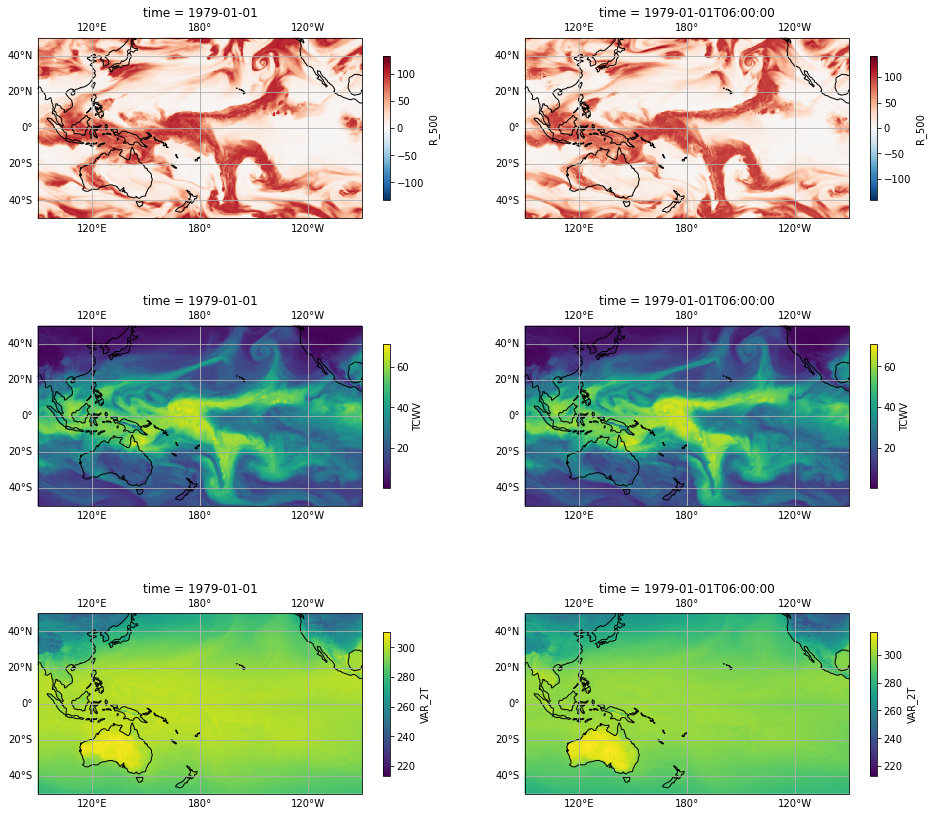

In [8]:
url = os.path.join(save_dir, '197901/era5-197901-000000.tar')
dataset = wds.WebDataset(url).decode(era5.decode_npz)
sample = next(iter(dataset))

input_dset = era5.dset_from_wds_sample(sample['input.npz'])
output_dset = era5.dset_from_wds_sample(sample['output.npz'])

era5.plot_2d(input_dset['R_500'], output_dset['R_500'],
             input_dset['TCWV'], output_dset['TCWV'],
             input_dset['VAR_2T'], output_dset['VAR_2T'],
             time=0,
             extents=[90, 270, -50, 50])

In [18]:
sample['input.npz']['lon']

array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02])